# W266 Final Project - Amazon Reviews

This notebook is to read in the cleaned data and work with the data in keras.

http://jmcauley.ucsd.edu/data/amazon/links.html

In [2]:
import pandas as pd
import gzip
import random
from collections import defaultdict
import seaborn as sns
import numpy as np
import re

from nltk.corpus import stopwords
import string

import tensorflow_hub as hub
import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.models import load_model

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

/home/lance_miles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0328 23:47:45.871829 139676801435456 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [61]:
def loadInitialData(loadDat = True):
    if loadDat == True:
        train_data_name = '../../train_data.pkl'
        train_data = pd.read_pickle(train_data_name)
        test_data_name = '../../test_data.pkl'
        test_data = pd.read_pickle(test_data_name)
        print('Successfully opened pickled data')
        
        return train_data, test_data, play_data

    else:
        files = ['reviews_Video_Games.json.gz', 
                 'reviews_Toys_and_Games.json.gz', 
                 'reviews_Sports_and_Outdoors.json.gz', 
                 'reviews_Movies_and_TV.json.gz',
                 'reviews_Kindle_Store.json.gz', 
                 'reviews_Home_and_Kitchen.json.gz',
                 'reviews_Health_and_Personal_Care.json.gz', 
                 'reviews_Electronics.json.gz',
                 'reviews_Clothing_Shoes_and_Jewelry.json.gz',
                 'reviews_Cell_Phones_and_Accessories.json.gz', 
                 'reviews_CDs_and_Vinyl.json.gz',
                 'reviews_Books.json.gz']
        filesNames = ['reviews_Video_Games', 
                      'reviews_Toys_and_Games',
                      'reviews_Sports_and_Outdoors', 
                      'reviews_Movies_and_TV',
                      'reviews_Kindle_Store', 
                      'reviews_Home_and_Kitchen',
                      'reviews_Health_and_Personal_Care', 
                      'reviews_Electronics',
                      'reviews_Clothing_Shoes_and_Jewelry',
                      'reviews_Cell_Phones_and_Accessories', 
                      'reviews_CDs_and_Vinyl',
                      'reviews_Books']

        print('Looks like you dont have the data.. Will pickle it for you for future use.')

        def dataFullSets(original, concatData, name):
            currentData = original
            appendData = pd.read_csv('../Data/%s'%(concatData))
            appendData['Product'] = name
            newDF = pd.concat([currentData,appendData], sort=True)
            return(newDF)

        train_data = pd.read_csv('../Data/%s_train.csv'%(filesNames[0]))
        train_data['Product'] = filesNames[0]
        test_data = pd.read_csv('../Data/%s_test.csv'%(filesNames[0]))
        test_data['Product'] = filesNames[0]

        random.seed(1203)

        for fileName in filesNames[1:]:
            concatName_train = fileName+'_train.csv'
            concatName_test = fileName+'_test.csv'

            train_data = dataFullSets(train_data, concatName_train, fileName).sample(frac=1)
            test_data = dataFullSets(test_data, concatName_test, fileName).sample(frac=1)

            print('Concatenated', fileName)

        print('Finished building train and test datasets.')

        train_data_name = '../../train_data.pkl'
        train_data.to_pickle(train_data_name)
        test_data_name = '../../test_data.pkl'
        test_data.to_pickle(test_data_name)

        print('Finished pickling for future use.')
        
        return train_data, test_data
        
train_data, test_data = loadInitialData(loadDat = True)

Successfully opened pickled data


In [62]:
train_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
83381,reviews_Electronics,B00AHPSTRY,"[5, 5]",1.0,just received my screen protector. it's going...,"08 14, 2013",A20EOZ5Q2Z8L1S,Vicki B.,0,SENDING IT BACK!,1376438400
7113,reviews_CDs_and_Vinyl,B00005AQ38,"[6, 6]",1.0,"But instead of the orchestra, we are treated t...","12 23, 2001",A16SS8HYJW7IEJ,"Mark Pollock ""educator""",0,Would be nice to hear the orchestra...,1009065600
58166,reviews_Health_and_Personal_Care,B0007P2OO8,"[0, 0]",5.0,Love this shaving soap and it was the best pri...,"01 15, 2013",A16O37AEI0Y3N,Richard Papaleo,1,Col. Conk is Famous,1358208000
35717,reviews_Home_and_Kitchen,B000AA89GW,"[0, 1]",1.0,It is impossible to join the two pieces of the...,"08 28, 2011",A2OV0337VRTSUV,AF,0,Impossible to close tightly... Makes a mess!!!,1314489600
26850,reviews_Electronics,B00529F3JW,"[2, 2]",1.0,There is no suction on this little vacuum clea...,"01 25, 2013",A3I0B7SO7OE7YG,Terry White,0,Mini Vacuum Cleaner,1359072000


In [63]:
test_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
11262,reviews_Home_and_Kitchen,B007EESTOY,"[0, 0]",5.0,Love this! Hot drinks stay hot for a couple ho...,"06 7, 2014",A1RAD5380383DT,Jennifer Manelis,1,Great insulation!!!,1402099200
16948,reviews_Health_and_Personal_Care,B0063X0K5I,"[1, 1]",1.0,Paid for next day shipping as reviews said thi...,"05 20, 2014",AYOQUNMV9L23E,David Murray,0,Does not ship in a cold pack,1400544000
18599,reviews_Video_Games,B009CL6LA6,"[0, 0]",5.0,I got it for my teenage grandson for Christmas...,"01 30, 2014",A1Y644EFDB8CZ8,"Elaine A. Stone ""Grandma from Oklahoma""",1,Headset,1391040000
6570,reviews_Cell_Phones_and_Accessories,B0042R8ICO,"[1, 1]",5.0,"This protector is good value. It's very clear,...","08 21, 2011",A1QSXZJMDRH5KY,Yancy,1,Great Clear Protector,1313884800
207,reviews_Toys_and_Games,B003F64T1M,"[4, 4]",5.0,I've had this truck for about a week now. Afte...,"07 18, 2013",A9F5P3EMJINOR,R. Moschgat Jr.,1,Maxstone,1374105600


In [6]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
#practice sentence
test_sentence = test_data['reviewText'].iloc[19]
test_sentence

'I could not ask for a better vacuum.  We just got this today and it was together within a minute.  Hubby used it on our wood floor and it picked up really well.  Then he did the 3 carpets that we have and they look almost brand new.  The funny thing is that my older cat batted at it and was hissing a little and the younger one ran out of the room as quick as he could.  It does not make a lot of noise and it a very good product to own.'

In [8]:
#prepare reviews to be split by words
#change to lowercase, remove punctuation and numbers
test_data_word_prep = re.sub("[^a-zA-Z']", " ", test_sentence).lower()
test_data_word_prep = re.sub("[\\s]+", " ", test_data_word_prep)
test_data_word_prep = decontracted(test_data_word_prep)
test_data_word_prep

'i could not ask for a better vacuum we just got this today and it was together within a minute hubby used it on our wood floor and it picked up really well then he did the carpets that we have and they look almost brand new the funny thing is that my older cat batted at it and was hissing a little and the younger one ran out of the room as quick as he could it does not make a lot of noise and it a very good product to own '

In [9]:
#list of words after processing
test_data_word_prep.strip().split()

['i',
 'could',
 'not',
 'ask',
 'for',
 'a',
 'better',
 'vacuum',
 'we',
 'just',
 'got',
 'this',
 'today',
 'and',
 'it',
 'was',
 'together',
 'within',
 'a',
 'minute',
 'hubby',
 'used',
 'it',
 'on',
 'our',
 'wood',
 'floor',
 'and',
 'it',
 'picked',
 'up',
 'really',
 'well',
 'then',
 'he',
 'did',
 'the',
 'carpets',
 'that',
 'we',
 'have',
 'and',
 'they',
 'look',
 'almost',
 'brand',
 'new',
 'the',
 'funny',
 'thing',
 'is',
 'that',
 'my',
 'older',
 'cat',
 'batted',
 'at',
 'it',
 'and',
 'was',
 'hissing',
 'a',
 'little',
 'and',
 'the',
 'younger',
 'one',
 'ran',
 'out',
 'of',
 'the',
 'room',
 'as',
 'quick',
 'as',
 'he',
 'could',
 'it',
 'does',
 'not',
 'make',
 'a',
 'lot',
 'of',
 'noise',
 'and',
 'it',
 'a',
 'very',
 'good',
 'product',
 'to',
 'own']

In [64]:
max_length = 1000

def loadData(loadDat = True):
    
    if loadDat == True:
        train_data_name = '../../train_data_cleaned.pkl'
        train_data = pd.read_pickle(train_data_name)
        test_data_name = '../../train_data_cleaned.pkl'
        test_data = pd.read_pickle(test_data_name)
        play_data_name = '../../play_data_cleaned.pkl'
        play_data = pd.read_pickle(play_data_name)
        print('Successfully opened pickled data')
        
        return train_data, test_data, play_data
    
    else:

        play_data = test_data[:10]

        def decontracted(phrase):
            phrase = re.sub(r"won\'t", "will not", phrase)
            phrase = re.sub(r"can\'t", "can not", phrase)
            phrase = re.sub(r"n\'t", " not", phrase)
            phrase = re.sub(r"\'re", " are", phrase)
            phrase = re.sub(r"\'s", " is", phrase)
            phrase = re.sub(r"\'d", " would", phrase)
            phrase = re.sub(r"\'ll", " will", phrase)
            phrase = re.sub(r"\'t", " not", phrase)
            phrase = re.sub(r"\'ve", " have", phrase)
            phrase = re.sub(r"\'m", " am", phrase)
            return phrase

        def prepReview(data):
            data_prep = str(data['reviewText'])
            data_prep = re.sub("[!?]", ".", data_prep)
            data_prep = re.sub("[^a-zA-Z']", " ", data_prep).lower()
            data_prep = re.sub("[\\s]+", " ", data_prep)
            data_prep = decontracted(data_prep)
            return data_prep

        #function to process review text and split into words
        def splitWords(data):
            return prepReview(data).split()[:max_length]

        #function to process review text and split into sentences
        def splitSentences(data):
            interim = prepReview(data).split()
            reviewTrunc = interim[:max_length]
            return ' '.join(reviewTrunc)


        #list of words from review into column
        sentences = play_data.apply(splitWords, axis=1)
        play_data.insert(loc = 11, column = 'sentenceWords', value = sentences)

        sentences = train_data.apply(splitWords, axis=1)
        train_data.insert(loc = 11,column = 'sentenceWords', value = sentences)

        sentences = test_data.apply(splitWords, axis=1)
        test_data.insert(loc = 11,column = 'sentenceWords', value = sentences)

        print('Finished working through the words for each sentences\nOn to the sentences..')

        #list of sentences from review into column
        sentences_split = play_data.apply(splitSentences, axis=1)
        play_data.insert(loc = 12, column = 'sentences', value = sentences_split)

        sentences_split = train_data.apply(splitSentences, axis=1)
        train_data.insert(loc = 12,column = 'sentences', value = sentences_split)

        sentences_split = test_data.apply(splitSentences, axis=1)
        test_data.insert(loc = 12,column = 'sentences', value = sentences_split)

        print('Finished sentences...\nNow moving on top pickling the data')

        train_data_name = '../../train_data_cleaned.pkl'
        train_data.to_pickle(train_data_name)
        test_data_name = '../../test_data_cleaned.pkl'
        test_data.to_pickle(test_data_name)
        play_data_name = '../../play_data_cleaned.pkl'
        play_data.to_pickle(play_data_name)

        print('Finished pickling for future use.')
        
        return train_data, test_data, play_data
        
train_data, test_data, play_data = loadData(loadDat = True)

Finished working through the words for each sentences
On to the sentences..
Finished sentences...
Now moving on top pickiling the data
Finished pickling for future use.


In [69]:
wordFreq = defaultdict(int)

wordData = train_data['sentenceWords']

for row in wordData:
    for word in row:
        wordFreq[word] += 1      

In [70]:
wordsForHist = list(wordFreq.values())

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Word Frequency for Train Data')

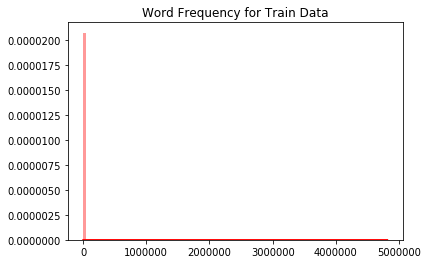

In [71]:
sns.distplot(wordsForHist, bins=100, color = 'red').set_title('Word Frequency for Train Data')

In [72]:
reviewLength = []

for row in wordData:
    reviewLength.append(len(row))

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Sentence Lengths for Train Data')

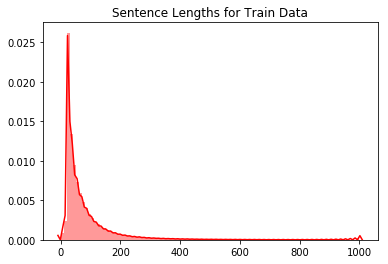

In [73]:
sns.distplot(reviewLength, bins=100, color = 'red').set_title('Sentence Lengths for Train Data')

In [74]:
print('Mean:',np.mean(reviewLength))
print('Median:',np.median(reviewLength))

Mean: 80.53101583333333
Median: 47.0


## Universal Sentence Encoder

In [75]:
#embedding = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

embedding = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

In [76]:
def getUniSentEmbeds(data):

    tf.logging.set_verbosity(tf.logging.ERROR)

    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        review_embeddings = sess.run(embedding((data)))

    review_embeddings = np.array(review_embeddings)
    return review_embeddings

In [77]:
try:
    play_data_name = '../../play_data_USE.npy'
    play_data_USE = np.load(play_data_name)
    print('Successfully opened pickled play data')
    
except FileNotFoundError:
    
    play_reviews = [str(rev) for rev in play_data['sentences']]
    
    print('Build USE for play Data')
    play_data_USE = getUniSentEmbeds(play_reviews)
    
    play_data_name = '../../play_data_USE.npy'
    np.save(play_data_name, play_data_USE)
    
    print('Finished pickling play data for future use.')

Build USE for play Data
Finished pickling play data for future use.


In [78]:
try:
    test_data_name = '../../train_data_USE.npy'
    test_data_USE = np.load(test_data_name)
    
    print('Successfully opened pickled test data')
    
except FileNotFoundError:
    
    testReviews = [str(rev) for rev in test_data['sentences']]
    
    test1 = testReviews[:20000]
    test2 = testReviews[20000:40000]
    test3 = testReviews[40000:60000]
    test4 = testReviews[60000:80000]
    test5 = testReviews[80000:100000]
    test6 = testReviews[100000:]

    print('Build USE for test1 Data')
    test_1_USE = getUniSentEmbeds(test1)
    
    print('Build USE for test2 Data')
    test_2_USE = getUniSentEmbeds(test2)
    
    print('Build USE for test3 Data')
    test_3_USE = getUniSentEmbeds(test3)
    
    print('Build USE for test4 Data')
    test_4_USE = getUniSentEmbeds(test4)
    
    print('Build USE for test5 Data')
    test_5_USE = getUniSentEmbeds(test5)
    
    print('Build USE for test6 Data')
    test_6_USE = getUniSentEmbeds(test6)
    
    test_data_USE = np.concatenate((test_1_USE, test_2_USE,
                                    test_3_USE, test_4_USE,
                                    test_5_USE, test_6_USE), axis=0)
    
    test_data_name = '../../test_data_USE.npy'
    np.save(test_data_name, test_data_USE)
    
    print('Finished pickling for future use.')

Build USE for test1 Data
Build USE for test2 Data
Build USE for test3 Data
Build USE for test4 Data
Build USE for test5 Data
Build USE for test6 Data
Finished pickling for future use.


In [79]:
test_data_USE.shape

(240000, 512)

In [ ]:
try:
    train_data_name = '../../train_data_USE.npy'
    train_data_USE = np.load(train_data_name)
    
    print('Successfully opened pickled train data')
    
except FileNotFoundError:
    
    trainReviews = [str(rev) for rev in train_data['sentences']]
    
    train1 = testReviews[:40000]
    train2 = testReviews[40000:80000]
    train3 = testReviews[80000:120000]
    train4 = testReviews[120000:160000]
    train5 = testReviews[160000:200000]
    train6 = testReviews[200000:240000]
    train7 = testReviews[240000:280000]
    train8 = testReviews[280000:320000]
    train9 = testReviews[320000:360000]
    train10 = testReviews[360000:400000]
    train11 = testReviews[400000:440000]
    train12 = testReviews[440000:480000]
    train13 = testReviews[480000:520000]
    train14 = testReviews[520000:560000]
    train15 = testReviews[560000:600000]
    train16 = testReviews[600000:640000]
    train17 = testReviews[640000:680000]
    train18 = testReviews[680000:720000]
    train19 = testReviews[720000:760000]
    train20 = testReviews[760000:800000]
    train21 = testReviews[800000:840000]
    train22 = testReviews[840000:880000]
    train23 = testReviews[880000:920000]
    train24 = testReviews[920000:960000]
    train25 = testReviews[960000:1000000]
    train26 = testReviews[1000000:1040000]
    train27 = testReviews[1040000:1080000]
    train28 = testReviews[1080000:1120000]
    train29 = testReviews[1120000:1160000]    
    train30 = testReviews[1160000:]
    
    print('Build USE for train1 Data')
    train1_use = getUniSentEmbeds(train1)
    
    print('Build USE for train2 Data')
    train2_use = getUniSentEmbeds(train2)
    
    print('Build USE for train3 Data')
    train3_use = getUniSentEmbeds(train3)
    
    print('Build USE for train4 Data')
    train4_use = getUniSentEmbeds(train4)
    
    print('Build USE for train5 Data')
    train5_use = getUniSentEmbeds(train5)
    
    print('Build USE for train6 Data')
    train6_use = getUniSentEmbeds(train6)
    
    print('Build USE for train7 Data')
    train7_use = getUniSentEmbeds(train7)
    
    print('Build USE for train8 Data')
    train8_use = getUniSentEmbeds(train8)
    
    print('Build USE for train9 Data')
    train9_use = getUniSentEmbeds(train9)
    
    print('Build USE for train10 Data')
    train10_use = getUniSentEmbeds(train10)
    
    print('Build USE for train11 Data')
    train11_use = getUniSentEmbeds(train11)
    
    print('Build USE for train12 Data')
    train12_use = getUniSentEmbeds(train12)
    
    print('Build USE for train13 Data')
    train13_use = getUniSentEmbeds(train13)
    
    print('Build USE for train14 Data')
    train14_use = getUniSentEmbeds(train14)
    
    print('Build USE for train15 Data')
    train15_use = getUniSentEmbeds(train15)
    
    print('Build USE for train16 Data')
    train16_use = getUniSentEmbeds(train16)
    
    print('Build USE for train17 Data')
    train17_use = getUniSentEmbeds(train17)
    
    print('Build USE for train18 Data')
    train18_use = getUniSentEmbeds(train18)
    
    print('Build USE for train19 Data')
    train19_use = getUniSentEmbeds(train19)
    
    print('Build USE for train20 Data')
    train20_use = getUniSentEmbeds(train20)
    
    print('Build USE for train21 Data')
    train21_use = getUniSentEmbeds(train21)
    
    print('Build USE for train22 Data')
    train22_use = getUniSentEmbeds(train22)
    
    print('Build USE for train23 Data')
    train23_use = getUniSentEmbeds(train23)
    
    print('Build USE for train24 Data')
    train24_use = getUniSentEmbeds(train24)
    
    print('Build USE for train25 Data')
    train25_use = getUniSentEmbeds(train25)
    
    print('Build USE for train26 Data')
    train26_use = getUniSentEmbeds(train26)
    
    print('Build USE for train27 Data')
    train27_use = getUniSentEmbeds(train27)
    
    print('Build USE for train28 Data')
    train28_use = getUniSentEmbeds(train28)
    
    print('Build USE for train29 Data')
    train29_use = getUniSentEmbeds(train29)
    
    print('Build USE for train30 Data')
    train30_use = getUniSentEmbeds(train30)                             
                             
    train_data_USE = np.concatenate((train1_use, train2_use
                                    train3_use, train4_use
                                    train5_use, train6_use
                                    train7_use, train8_use
                                    train9_use, train10_use
                                    train11_use, train12_use
                                    train13_use, train14_use
                                    train15_use, train16_use
                                    train17_use, train18_use
                                    train19_use, train20_use
                                    train21_use, train22_use
                                    train23_use, train24_use
                                    train25_use, train26_use
                                    train27_use, train28_use
                                    train29_use, train30_use), axis=0)
                             
    train_data_name = '../../train_data_USE.npy'
    np.save(train_data_name, train_data_USE)   
    
    print('Finished pickling train data for future use.')

## Keras

### TO DO:

**Model Efforts**
* Initialize and access word2vec embeddings in CNN
* Initialize and access glove embeddings in CNN
* Index Universal Sentence Embeddings for concatenation in CNN

**Text Processing**
* Contractions
* Review Length (some as large as 6000?!)
* Stopwords

### Baseline Models
#### CNN
* Trained Embeddings
* Word2Vec
* Glove

#### Softmax
* Universal Sentence Encoder (USE)

### Models to Test
#### CNN (Concatentation)
* Trained Embeddings + USE
* Word2Vec + USE
* Glove + USE

**If extra time**
* Zero shot learning - IMDB Reviews
* Sentiment embeddings

In [ ]:
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)

list_sentences_train = list(train_data['sentenceWords'])
list_sentences_test = list(test_data['sentenceWords'])

tokenizer = Tokenizer()   #num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)


X_train = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
X_train_labels = np.array(train_data['sentiment'])

X_test = pad_sequences(list_tokenized_test, maxlen=max_length, padding='post')
X_test_labels = np.array(test_data['sentiment'])

X_train_labels.shape
X_train.shape 

X_test.shape
X_test_labels.shape

word_index = tokenizer.word_index

## Word2Vec Embeddings

In [ ]:
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
#https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights
word_vectors = KeyedVectors.load_word2vec_format('../../GoogleNews-vectors-negative300.bin.gz', binary=True)

embedDim=300
vocabulary_size=len(word_index)+1
embedding_matrix_w2v = np.zeros((vocabulary_size, embedDim))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix_w2v[i] = embedding_vector
    except KeyError:
        embedding_matrix_w2v[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

del(word_vectors)

In [ ]:
embedding_matrix_w2v

In [ ]:
embedding_matrix_w2v.shape

## Glove Embeddings

In [ ]:
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
#https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights

# embeddings_index = dict()
# f = open('../../glove.840B.300d.txt')
# for line in f:
#     values = line.split()
#     word = ''.join(values[:-300])
#     coefs = np.asarray(values[-300:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# embedding_matrix_glove = np.zeros((vocabulary_size, embedDim))
# for word, i in word_index.items():
#     try:
#         embedding_vector = embeddings_index.get(word)
#         embedding_matrix_glove[i] = embedding_vector
#     except KeyError:
#         embedding_matrix_glove[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

In [ ]:
# https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
# import warnings
# warnings.filterwarnings("ignore")

_ = glove2word2vec(glove_input_file='../../glove.840B.300d.txt', 
                   word2vec_output_file='../../gensim_glove_vectors.txt')

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('../../gensim_glove_vectors.txt', binary=False)

In [ ]:
embedding_matrix_glove = np.zeros((vocabulary_size, embedDim))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix_glove[i] = embedding_vector
    except KeyError:
        embedding_matrix_glove[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

del(word_vectors)

In [ ]:
embedding_matrix_glove

In [ ]:
embedding_matrix_glove.shape

## CNN Model

In [ ]:
# https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

def CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds=None, use=True, length=maxlen,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10):
    
    k1 = kernelSize[0]
    k2 = kernelSize[1]
    k3 = kernelSize[2]
    
    k1_inputs = Input(shape=(length,))
    k2_inputs = Input(shape=(length,))
    k3_inputs = Input(shape=(length,))
       
    if embeds == None:
        k1_embeddings = Embedding(vocab, embedDepth)(k1_inputs)
        k2_embeddings = Embedding(vocab, embedDepth)(k2_inputs)
        k3_embeddings = Embedding(vocab, embedDepth)(k3_inputs)

    elif embeds == 'w2v':
        k1_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=True)(k1_inputs)
        k2_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=True)(k2_inputs)
        k3_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=True)(k3_inputs)
        
    elif embeds == 'Glove':
        k1_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=True)(k1_inputs)
        k2_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=True)(k2_inputs)
        k3_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=True)(k3_inputs)
    else:
        print('Specify embeds correctly. Currently embeds =',embeds)
        return
    
    k1_conv = Conv1D(filters=numFilters, kernel_size=k1, activation='relu')(k1_embeddings)
    k1_dropout = Dropout(dropOut)(k1_conv)
    k1_maxPool = MaxPooling1D(pool_size=pool)(k1_dropout)
    k1_flatten = Flatten()(k1_maxPool)

    k2_conv = Conv1D(filters=numFilters, kernel_size=k2, activation='relu')(k2_embeddings)
    k2_dropout = Dropout(dropOut)(k2_conv)
    k2_maxPool = MaxPooling1D(pool_size=pool)(k2_dropout)
    k2_flatten = Flatten()(k2_maxPool)

    k3_conv = Conv1D(filters=numFilters, kernel_size=k3, activation='relu')(k3_embeddings)
    k3_dropout = Dropout(dropOut)(k3_conv)
    k3_maxPool = MaxPooling1D(pool_size=pool)(k3_dropout)
    k3_flatten = Flatten()(k3_maxPool)

    if use == True:
        use_inputs = Input(shape=(512,))
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten, use_inputs])
    else:
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten])
        
    denseLayer = Dense(denseInputs, activation='relu')(concat_kern)
    cnnOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    if use == True:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs, use_inputs], outputs=cnnOutputs)
    else:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs], outputs=cnnOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
        
    #plot_model(model, show_shapes=True, to_file='CNNModel.png')
        
    return model


In [ ]:
#embeds can be None, 'w2v', or 'Glove'
#if use is True, you need to adjust the cnnModel.fit to include the USE outputs as an input

# cnnModel = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
#                  dropOut=0.5, embeds='Glove', use=False, length=maxlen,
#                  vocab = vocabulary_size, pool = 2, denseInputs = 10)

# cnnModel.fit([X_train,X_train,X_train], X_train_labels, epochs=10, batch_size=16)

cnnModel = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='Glove', use=True, length=maxlen,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel.fit([X_train,X_train,X_train, train_data_USE], X_train_labels, epochs=10, batch_size=16)